In [1]:
import pandas as pd
import seaborn as sns 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

import sys
sys.path.append('../../code')
import leakage
import cobra

In [2]:
data_folder = Path('../../data')
figure_folder = Path('../../Figures/')
div_folder = Path('../../../data/this_project/5_div/')


## Get extracellular data

In [3]:
sintef_fn = data_folder / 'this_project/1_e_coli_batch_cultures/1ABE_merged_metabolomics_data.csv'
sintef_od_fn = data_folder / 'this_project/1_e_coli_batch_cultures/1H_OD_and_gDW.csv'

paczia_fn = data_folder / 'paczia_2012' / 'e_coli'/'e_coli_exometabolites.csv'
paczia_od_fn = data_folder / 'paczia_2012' / 'e_coli'/'e_coli_OD.csv'

vila_fn = data_folder / 'vila_2023' / 'Targeted_LCMS_WithOD.csv'


## Sintef

In [4]:
sintef_df = pd.read_csv(sintef_fn, index_col=0)
# Only intrerested in the absolute quantification
sintef_df = sintef_df.loc[sintef_df['Concentration [uM]'].notna()]

In [5]:
sintef_od = pd.read_csv(sintef_od_fn, index_col = 0)

In [6]:
sintef_od_dict = sintef_od.set_index(['Hours', 'Bioreactor'])['OD'].to_dict()

In [7]:
sintef_od_dict[0, np.nan] = np.nan

In [8]:
sintef_df['OD'] = sintef_df.apply(lambda x: sintef_od_dict[x['Hours'], x['Bioreactor']], axis=1)

#### Delta concentration

In [9]:
sintef_t0 = sintef_df.loc[sintef_df.Hours ==0]
sintef_conc0_dict = sintef_t0.groupby(['Carbon source', 'Metabolite']).mean('Concentration [uM]')['Concentration [uM]'].to_dict()

In [10]:
def get_delta_concentration(x):
    c = x['Concentration [uM]']
    try:
        c0 = sintef_conc0_dict[x['Carbon source'], x['Metabolite']]
    except KeyError:
        return c
    else:
        return c-c0

In [11]:
sintef_df['Delta concentration [uM]'] = sintef_df.apply(lambda x:get_delta_concentration(x), axis = 1)


In [12]:
sintef_df.loc[sintef_df['Delta concentration [uM]']< 0, 'Delta concentration [uM]'] = np.nan

In [13]:
sintef_df.loc[sintef_df.Timepoint==4, 'Phase'] = 'Stationary'
sintef_df.loc[sintef_df.Timepoint.isin([1,2,3]), 'Phase'] = 'Exponential'
sintef_df['Dataset'] = 'This project'

## Paczia

In [14]:
paczia_df, paczia_df_std = leakage.get_concentrations(paczia_fn.parent, 'e_coli')

In [15]:
paczia_df = paczia_df.loc[2:] - paczia_df.loc[1]

In [16]:
paczia_od = pd.read_csv(paczia_od_fn)

In [17]:
paczia_time_to_od = paczia_od.set_index('Time')['OD mean'].to_dict()

In [18]:
paczia_df['2PG'] =  paczia_df['3PG'] = paczia_df['23PG']/2
paczia_df['RU5P'] = paczia_df['X5P'] = paczia_df['RU5P+X5P']/2

In [19]:
paczia_df.drop(columns=['23PG', 'RU5P+X5P'], inplace=True)

In [20]:
paczia_dfL = paczia_df.reset_index().melt(id_vars='Time', var_name='Abbreviation', value_name='Delta concentration [uM]')
paczia_dfL['OD'] = paczia_dfL.Time.map(paczia_time_to_od)

In [21]:
mapping_df = pd.read_csv(data_folder / 'this_project/5_div/5B_id_mapping.csv', index_col=0)
met_abrv_to_id = mapping_df['Ecoli metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()
met_name_to_abrv_paczia = {value:key for key, value in met_abrv_to_name.items()}
met_abrv_to_name['SER'] = 'Serine'
met_abrv_to_name['DHAP'] = 'Dihydroxyacetone phosphate'
met_abrv_to_name['2PG'] = '2-phosphoglycerate'
met_abrv_to_name['3PG'] = '3-phosphoglycerate'
met_abrv_to_name['X5P'] = 'Xylulose-5-phosphate'
met_abrv_to_name['RU5P'] = 'Ribulose-5-phosphate'

In [22]:
paczia_dfL['Metabolite'] = paczia_dfL.Abbreviation.map(met_abrv_to_name)

In [23]:
paczia_dfL.loc[paczia_dfL.Time <= 10, 'Phase'] = 'Exponential'
paczia_dfL.loc[paczia_dfL.Time > 10, 'Phase'] = 'Stationary'

In [24]:
paczia_dfL.loc[paczia_dfL['Delta concentration [uM]'] < 0, 'Delta concentration [uM]'] = np.nan

In [25]:
paczia_dfL['Dataset'] = 'Paczia et al.'

## Vila


In [26]:
vila_df = pd.read_csv(vila_fn)
vila_df = vila_df.loc[vila_df.Strain == 'Ecoli']
metname_translate_dict = {'Acetic acid': 'Acetate',
'Acetyl-ornithine': 'Acetyl-ornithine',
'Alanine': 'Alanine',
'Asparagine': 'Asparagine',
'Butyric acid': 'Butyrate',
'Citric acid': 'Citrate',
'Fumaric acid': 'Fumarate',
'Glycine': 'Glycine',
'Lactic acid': 'Lactate',
'Methionine': 'Methionine',
'Propionic acid': 'Propionate',
'Putrescine': 'Putrescine',
'Pyruvic acid': 'Pyruvate',
'Serine': 'Serine',
'Succinic acid': 'Succinate',
'Valeric acid':'Valerate',
'Valine': 'Valine',
'alpha-Ketoglutaric acid': 'Alpha-ketoglutarate',
'beta-Hydroxybutyric acid': 'Beta-hydroxybutyrate'}
vila_df['Metabolite'] = vila_df.Metabolite.map(metname_translate_dict)

In [27]:
vila_df = vila_df.loc[vila_df['Metabolite'] != vila_df['Carbon_Source']]

In [28]:
vila_df['Delta concentration [uM]'] = vila_df.Metabolite_Conc
vila_df.loc[vila_df.Metabolite_Conc==0, 'Delta concentration [uM]'] = np.nan

In [29]:
vila_peak_df = pd.read_csv(data_folder / 'vila_2023' / 'growth_curves_peaktimes.csv', index_col=0)
strain_cs_to_PT = vila_peak_df.groupby(['Strain', 'Carbon source']).agg({'Peak time':'max'}).to_dict()['Peak time']


In [30]:
time_buffer = 2
for i, row in vila_df.iterrows():
    peak_time = strain_cs_to_PT[row['Strain'], row['Carbon_Source']]
    if row['Timepoint'] < peak_time+2:
        vila_df.at[i, 'Phase'] = 'Exponential'
    else:
        vila_df.at[i, 'Phase'] = 'Stationary'

In [31]:
vila_df['Hours'] = vila_df['Timepoint']
vila_df.rename(columns={'Carbon_Source':'Carbon source'}, inplace=True)

In [32]:
vila_df['Dataset'] = 'Vila et al.'

## Join dataframes

In [33]:
vila_mets = set(vila_df.Metabolite.unique())
paczia_mets = set(paczia_dfL.Metabolite.unique())
sintef_mets = set(sintef_df.Metabolite.unique())
# ps_mets = vila_mets & sintef_mets
vila_only = vila_mets - paczia_mets - sintef_mets

In [34]:
paczia_dfL['Hours'] = paczia_dfL['Time']
paczia_dfL['Carbon source'] = 'Glucose'

In [35]:
sintef_df.columns

Index(['Sample_id', 'Carbon source', 'Metabolite', 'Concentration [uM]',
       'Hours', 'Bioreactor', 'AUC [gDW*h/L]', 'Z-score', 'Timepoint', 'OD',
       'Delta concentration [uM]', 'Phase', 'Dataset'],
      dtype='object')

In [36]:
df_ex = pd.concat([sintef_df, paczia_dfL, vila_df])[['Hours', 'Delta concentration [uM]', 'OD', 'Phase', 'Metabolite', 'Carbon source', 'Dataset']]

In [37]:
df_ex = df_ex.loc[~df_ex.isna().any(axis=1)]

In [38]:
df_ex_g = df_ex.groupby(['Metabolite', 'Phase', 'Carbon source']).agg({'Delta concentration [uM]':'mean', 'OD':'mean'}).reset_index()

In [39]:
df_ex_g.loc[df_ex_g.Phase=='Exponential'].sort_values(by = 'Delta concentration [uM]', ascending=True).head(30)

,Metabolite,Phase,Carbon source,Delta concentration [uM],OD
127,Creatine,Exponential,L-malate,0.000752,1.600000
125,Creatine,Exponential,Galactose,0.002948,2.182400
380,Tyrosine,Exponential,Galactose,0.003019,2.152000
126,Creatine,Exponential,L-alanine,0.003381,0.453333
383,Tyrosine,Exponential,L-malate,0.006824,1.600000
339,Sebacoyl-l-carnitine (c10-dc),Exponential,L-malate,0.008052,1.875000
374,Trans-aconitate,Exponential,L-malate,0.011151,1.537143
372,Trans-aconitate,Exponential,Galactose,0.011359,1.636250
337,Sebacoyl-l-carnitine (c10-dc),Exponential,Galactose,0.013601,2.260000
285,Pipecolic acid,Exponential,L-malate,0.015390,1.746667


## Get intracellular literature data

In [40]:
conditions_fn = data_folder / 'this_project/4_paired_metabolomics_live_dead/4F_mapped_intracellular_conc.csv'
conditions_df = pd.read_csv(conditions_fn, index_col=0)

In [41]:
list(conditions_df.Metabolite.unique())

['Alanine',
 'Alpha-aminoadipate',
 'Asparagine',
 'Aspartate',
 'Beta-alanine',
 'Cis-aconitate',
 'Creatine',
 'Deoxycarnitine (deoxy-c0)',
 'Gamma-aminobutyrate',
 'Glutamate',
 'Glutamine',
 'Glutarate',
 'Glutarylcarnitine (c5-dc)',
 'Isocitrate',
 'Isoleucine',
 'Lactate',
 'Leucine',
 'Lysine',
 'Malate',
 'Methionine',
 'NAD',
 'Phenylalanine',
 'Pipecolic acid',
 'Proline',
 'Sebacoyl-l-carnitine (c10-dc)',
 'Serine',
 'Succinate',
 'Trans-aconitate',
 'Tyrosine',
 'Valine',
 'Citrate',
 'Acetate',
 'Formate',
 'Propanoate',
 'Pyruvate',
 'Alpha-aminobutyrate',
 'Glycine',
 'Hexoses',
 'Glucose-6-phosphate',
 'Fructose-6-phosphate',
 'Fructose-1,6-bisphosphate',
 'Dihydroxyacetone phosphate',
 'Glyceraldehyde-3-phosphate',
 '2-phosphoglycerate',
 '3-phosphoglycerate',
 'Phosphoenolpyruvate',
 'Ribose-5-phosphate',
 'Ribulose-5-phosphate',
 'Xylulose-5-phosphate',
 'Erythrose-4-phosphate',
 'Oxaloacetate',
 'Threonine',
 'Homoserine',
 'Tryptophan',
 'Histidine',
 'Arginine',
 

# Merge intracellular and extracellular

In [42]:
df_ex['Carbon source'] = df_ex['Carbon source'].str.capitalize()
df_ex['Carbon source'] = df_ex['Carbon source'].replace({'D-glucose': 'Glucose'})

In [43]:
df = pd.merge(left = df_ex, right = conditions_df, left_on=['Metabolite', 'Carbon source', 'Phase'], 
              right_on=['Metabolite', 'Carbon source', 'Phase'], how = 'left')


In [44]:
df.columns

Index(['Hours', 'Delta concentration [uM]', 'OD', 'Phase', 'Metabolite',
       'Carbon source', 'Dataset', 'Intracellular concentration [uM]',
       'Error [uM]', 'SEM [uM]', '# values', 'idx concentration sheet', 'Min',
       'Max', 'LB', 'Min LB', 'UB', 'Max UB'],
      dtype='object')

In [45]:
# df.to_csv(figure_folder / '5B_exometabolites.csv', index=False)

In [46]:
df = df.loc[df['Intracellular concentration [uM]'].notna()].copy()

In [47]:
total_cell_volume_per_od = 3.6 # uL per OD per mL Total cell volume conversion, see Volkmer and Heinemann 2011, https://pmc.ncbi.nlm.nih.gov/articles/PMC3146540/


In [48]:
# 1e-6 to convert from uL to L and 1e3 to convert from ml to L (so net 1e-3)
df['Corresponding Ex. concentration [uM]']= total_cell_volume_per_od*df['OD']*1e-3*df['Intracellular concentration [uM]']


In [49]:
df['Fraction of cells needed'] = df['Delta concentration [uM]']/df['Corresponding Ex. concentration [uM]']

In [50]:
df = df.loc[df['Delta concentration [uM]']>0]

In [51]:
df.sort_values(by = 'Metabolite', inplace=True)

In [52]:
df.Metabolite.nunique()

51

In [53]:
df['Fraction of cells needed'].sort_values()

264         0.000368
586         0.000765
934         0.000883
465         0.001499
600         0.001527
            ...     
1494    16246.558800
1583    16640.855982
1598    17387.702447
1828    17530.469304
1728    23188.778058
Name: Fraction of cells needed, Length: 1508, dtype: float64

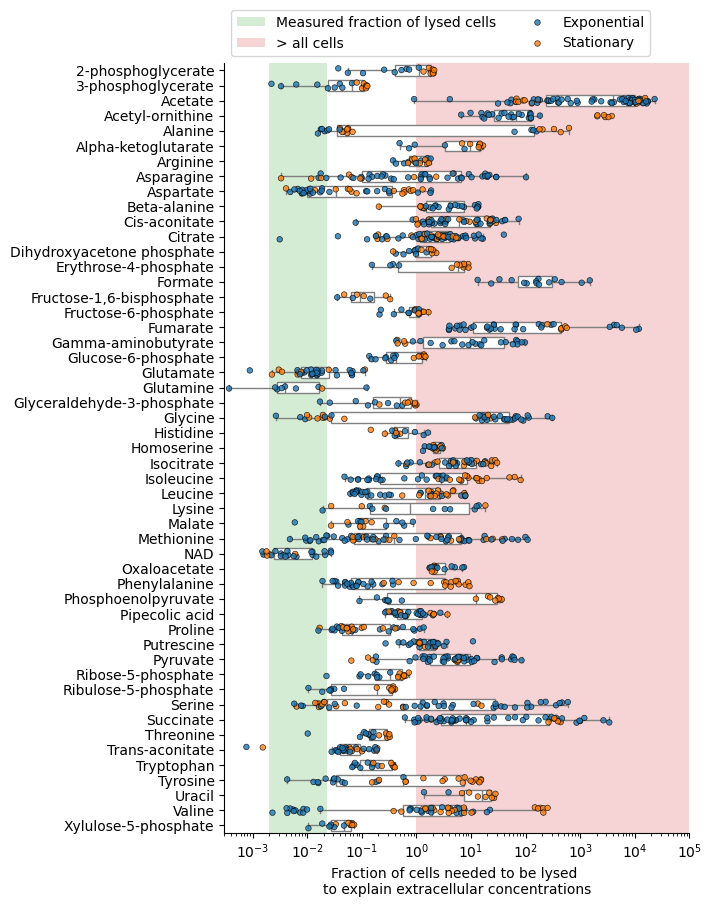

In [54]:
fig, ax = plt.subplots(1, figsize = (6, 10))
ax.set_xscale('log')

ax.axvspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured fraction of lysed cells', zorder = 0, linewidth = 0)
ax.axvspan(1, 1e5, color = 'C3', alpha = 0.2, label = '> all cells', zorder = 0, linewidth = 0)
l = sns.boxplot(df, x = 'Fraction of cells needed', y = 'Metabolite', fill=True,gap=.1,
                ax = ax, legend = None, color = 'w',fliersize = 0, linecolor = 'grey')
sns.stripplot(data = df, x = 'Fraction of cells needed', y = 'Metabolite', ax = ax, edgecolor = 'k', 
              linewidth = 0.5, size=4, jitter=0.2, hue = 'Phase', alpha = 0.8)#, color = 'C0')
ax.set_xlim(3e-4, 1e5)
ax.set_ylabel('')
ax.set_xlabel('Fraction of cells needed to be lysed \nto explain extracellular concentrations')
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 2, title = '')
sns.despine()
plt.savefig(figure_folder / '5F_fraction_of_cells_needed.pdf', bbox_inches='tight')

3.7e-04, 2.3e+04


/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_53440/1699186736.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([short_labels.get(lbl.get_text(), lbl.get_text()) for lbl in ax.get_xticklabels()],


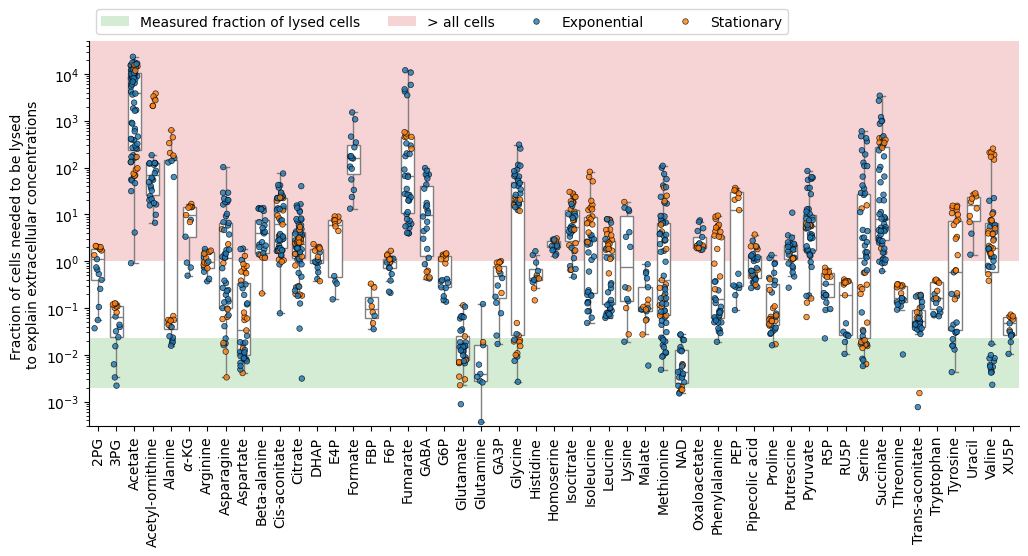

In [55]:
fig, ax = plt.subplots(1, figsize = (12, 5))
# ax.set_yscale('log')

ax.axhspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured fraction of lysed cells', zorder = 0, linewidth = 0)
ax.axhspan(1, 1e5, color = 'C3', alpha = 0.2, label = '> all cells', zorder = 0, linewidth = 0)
l = sns.boxplot(df, y = 'Fraction of cells needed', x = 'Metabolite', fill=True,gap=.1,
                ax = ax, legend = None, color = 'w',fliersize = 0, linecolor = 'grey', log_scale=True)
sns.stripplot(data = df,y = 'Fraction of cells needed', x = 'Metabolite', ax = ax, edgecolor = 'k', 
              linewidth = 0.5, size=4, jitter=0.2, hue = 'Phase', alpha = 0.8, log_scale=True)#, color = 'C0')
ax.set_ylim(3e-4, 5e4)
print(f'{df['Fraction of cells needed'].min():.1e}, {df['Fraction of cells needed'].max():.1e}')
ax.set_xlabel('')
ax.set_ylabel('Fraction of cells needed to be lysed \nto explain extracellular concentrations')
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 4, title = '')
sns.despine()

short_labels = {
    '2-phosphoglycerate': '2PG',
    '3-phosphoglycerate': '3PG',
    'Xylulose-5-phosphate': 'XU5P',
    'Ribulose-5-phosphate': 'RU5P',
    'Dihydroxyacetone phosphate': 'DHAP',
    'Alpha-ketoglutarate': r'$\alpha$-KG',
    'Erythrose-4-phosphate': 'E4P',
    'Glyceraldehyde-3-phosphate': 'GA3P',
    'Fructose-6-phosphate': 'F6P',
    'Glucose-6-phosphate': 'G6P',
    'Phosphoenolpyruvate': 'PEP',
    'Fructose-1,6-bisphosphate': 'FBP',
    'Gamma-aminobutyrate': 'GABA',
    'Ribose-5-phosphate': 'R5P',

}

ax.set_xticklabels([short_labels.get(lbl.get_text(), lbl.get_text()) for lbl in ax.get_xticklabels()],
                    rotation=90, ha='center')

plt.savefig(figure_folder / '5F_fraction_of_cells_needed_horizontal.pdf', bbox_inches='tight')

In [56]:
df['Below threshold'] = df['Fraction of cells needed']<0.023

In [57]:
threshold = 0.023
total_counts = df.groupby('Metabolite').size()
below_counts = df[df['Fraction of cells needed'] < threshold].groupby('Metabolite').size()
fraction_below = (below_counts / total_counts).fillna(0)
fraction_below = pd.DataFrame(fraction_below, columns=['Fraction of cells below threshold'])
# ax = fraction_below.sort_values().plot(kind='bar', figsize=(10, 4), color='C0', edgecolor='k')
# ax.axhline(0.5, c = 'k', ls ='--')
# ax.annotate('50% threshold', xy=(0.5, 0.55), xytext=(0.5, 0.52),
#             fontsize=10)
# sns.despine()
# ax.set_ylabel('Fraction of extracellular concentrations below \n the threshold explained by cell lysis')
# ax.set_xlabel('')
# plt.hist(fraction_below, bins=20, edgecolor='k')

In [58]:
df_mean = df.groupby('Metabolite').agg({'Delta concentration [uM]':['mean','std'], 'Intracellular concentration [uM]':['mean','std']}) 

In [59]:
df_mean.columns = ['_'.join(col).strip() for col in df_mean.columns.values]

In [60]:
df_mean['Ratio'] = df_mean['Intracellular concentration [uM]_mean'] / df_mean['Delta concentration [uM]_mean']

In [61]:
df['Ratio'] = df['Intracellular concentration [uM]'] / df['Delta concentration [uM]']

In [62]:
df_mean.sort_values(by='Ratio', ascending=False, inplace=True)

In [63]:
fraction_below['Above 50%'] = fraction_below['Fraction of cells below threshold'] > 0.5


In [64]:
fraction_below.sort_values(by='Fraction of cells below threshold', ascending=False, inplace=True)

In [65]:
above_50_dict = fraction_below['Above 50%'].to_dict()

In [66]:
df['Above 50%'] = df['Metabolite'].map(above_50_dict)

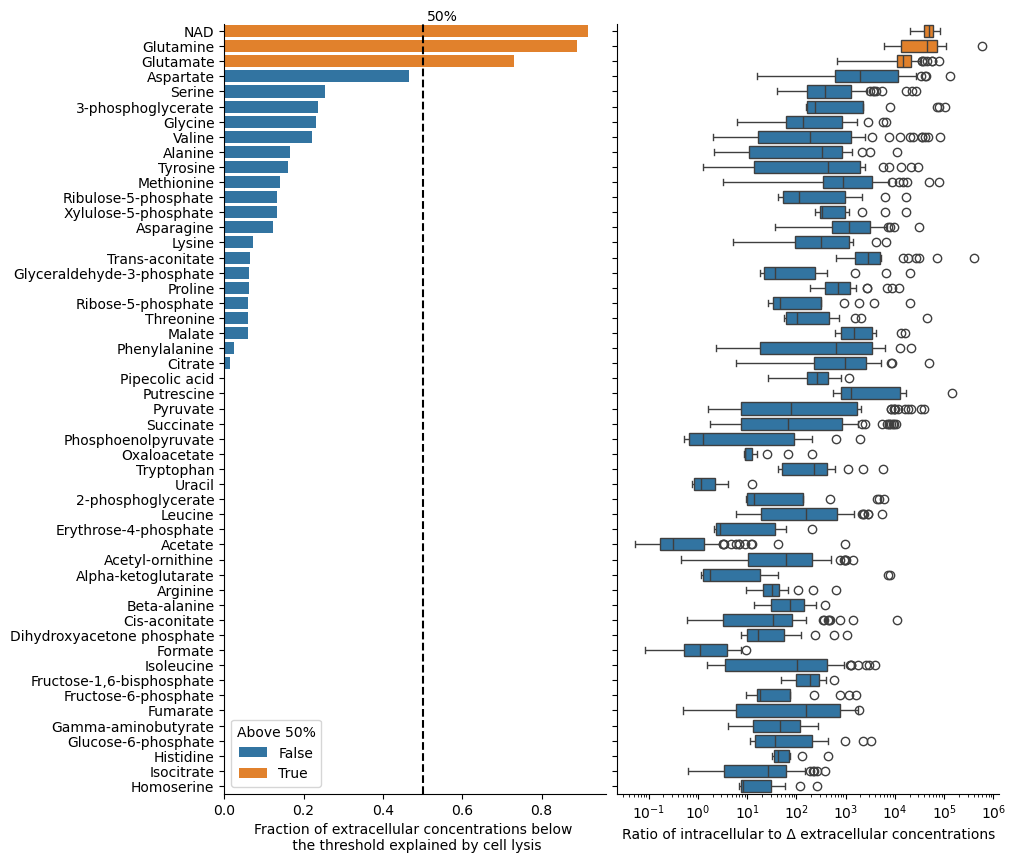

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharey=True)

sns.barplot(data = fraction_below, y = fraction_below.index, x = 'Fraction of cells below threshold', hue = 'Above 50%',
            ax = ax1, orient='horizontal')
ax1.axvline(0.5, c = 'k', ls ='--')
ax1.text(0.51, -0.5, '50%', ha='left', va='bottom', fontsize=10)
ax1.set_ylabel('')

sns.boxplot(data = df, x = 'Ratio', y = 'Metabolite', ax = ax2, hue = 'Above 50%', legend=None,)
ax2.set_xscale('log')

ax1.set_xlabel('Fraction of extracellular concentrations below \n the threshold explained by cell lysis')
ax2.set_xlabel('Ratio of intracellular to Δ extracellular concentrations')
plt.subplots_adjust(wspace=0.03)
sns.despine()
plt.savefig(figure_folder / '5F_fraction_of_cells_below_threshold.png', bbox_inches='tight', dpi=300)
plt.savefig(figure_folder / '5F_fraction_of_cells_below_threshold.pdf', bbox_inches='tight')




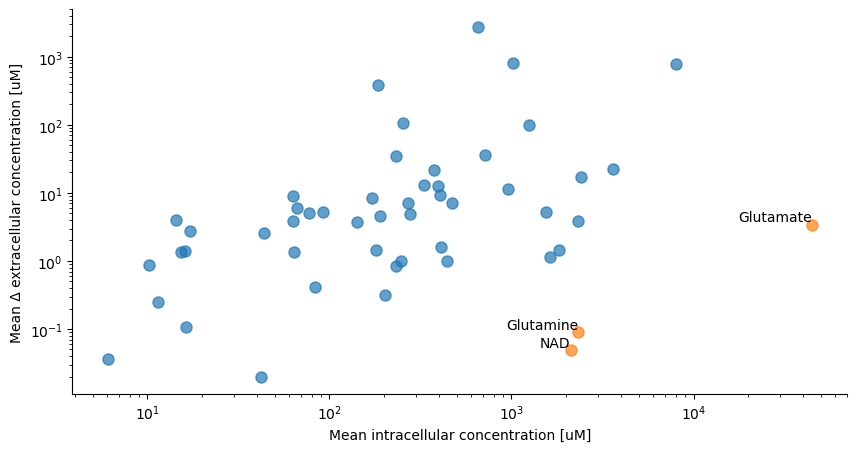

In [68]:
df_mean['Above 50%'] = df_mean.index.map(above_50_dict)
fig, ax = plt.subplots(figsize=(10, 5))
for i, row in df_mean.iterrows():
    ax.errorbar(x=row['Intracellular concentration [uM]_mean'],
                 y=row['Delta concentration [uM]_mean'],
                #  xerr=row['Intracellular concentration [uM]_std'],
                #  yerr=row['Delta concentration [uM]_std'],
                # size=5,
                markersize=8,
                 fmt='o', alpha=0.7, capsize=3, elinewidth=1, 
                 color='C1' if row['Above 50%'] else 'C0', label='Above 50%' if row['Above 50%'] else 'Below 50%')
    if row['Above 50%']:
        ax.text(row['Intracellular concentration [uM]_mean'], row['Delta concentration [uM]_mean'], i, fontsize=10, ha='right', va='bottom')

ax.set_xlabel('Mean intracellular concentration [uM]')
ax.set_ylabel('Mean Δ extracellular concentration [uM]')
# ax = sns.scatterplot(data = df_mean, x = 'Intracellular concentration [uM]_mean', y = 'Delta concentration [uM]_mean', 
#                    hue = 'Above 50%')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_aspect(1)    
sns.despine()
plt.savefig(figure_folder / '5F_intracellular_vs_delta_extracellular.png', bbox_inches='tight', dpi=300)
plt.savefig(figure_folder / '5F_intracellular_vs_delta_extracellular.pdf', bbox_inches='tight')

In [69]:
df.loc[df['Metabolite']=='Malate']

,Hours,Delta concentration [uM],OD,Phase,Metabolite,Carbon source,Dataset,Intracellular concentration [uM],Error [uM],SEM [uM],...,Max,LB,Min LB,UB,Max UB,Corresponding Ex. concentration [uM],Fraction of cells needed,Below threshold,Ratio,Above 50%
423,14.0,0.527758,1.408,Exponential,Malate,Galactose,This project,1832.866667,1334.028411,680.62674,...,3450.0,498.838256,308.167643,3166.895077,3890.0,9.290435,0.056807,False,3472.928889,False
417,22.0,2.258571,2.270,Stationary,Malate,L-alanine,This project,1832.866667,1334.028411,680.62674,...,3450.0,498.838256,308.167643,3166.895077,3890.0,14.978186,0.150791,False,811.515924,False
422,16.0,0.447533,0.734,Exponential,Malate,L-alanine,This project,1832.866667,1334.028411,680.62674,...,3450.0,498.838256,308.167643,3166.895077,3890.0,4.843167,0.092405,False,4095.492106,False
421,10.0,0.136800,0.220,Exponential,Malate,L-alanine,This project,1832.866667,1334.028411,680.62674,...,3450.0,498.838256,308.167643,3166.895077,3890.0,1.451630,0.094239,False,13398.102334,False
420,10.0,0.904199,0.230,Exponential,Malate,L-alanine,This project,1832.866667,1334.028411,680.62674,...,3450.0,498.838256,308.167643,3166.895077,3890.0,1.517614,0.595803,False,2027.061545,False
419,16.0,2.950339,0.810,Exponential,Malate,L-alanine,This project,1832.866667,1334.028411,680.62674,...,3450.0,498.838256,308.167643,3166.895077,3890.0,5.344639,0.552018,False,621.239320,False
416,16.0,1.207569,2.152,Exponential,Malate,Galactose,This project,1832.866667,1334.028411,680.62674,...,3450.0,498.838256,308.167643,3166.895077,3890.0,14.199585,0.085043,False,1517.815291,False
418,20.0,2.786907,3.600,Stationary,Malate,Galactose,This project,1832.866667,1334.028411,680.62674,...,3450.0,498.838256,308.167643,3166.895077,3890.0,23.753952,0.117324,False,657.670459,False
414,22.0,1.744749,2.500,Stationary,Malate,L-alanine,This project,1832.866667,1334.028411,680.62674,...,3450.0,498.838256,308.167643,3166.895077,3890.0,16.495800,0.105769,False,1050.504443,False
415,18.0,0.511312,2.850,Stationary,Malate,Galactose,This project,1832.866667,1334.028411,680.62674,...,3450.0,498.838256,308.167643,3166.895077,3890.0,18.805212,0.027190,False,3584.632249,False


In [70]:
threshold = 0.023
counts_below = df[df['Fraction of cells needed'] < threshold].groupby('Metabolite').size()
print(counts_below)

Metabolite
3-phosphoglycerate             4
Alanine                        4
Asparagine                     6
Aspartate                     20
Citrate                        1
Glutamate                     27
Glutamine                      8
Glyceraldehyde-3-phosphate     1
Glycine                       10
Lysine                         1
Malate                         1
Methionine                    10
NAD                           22
Phenylalanine                  1
Proline                        2
Ribose-5-phosphate             1
Ribulose-5-phosphate           2
Serine                        14
Threonine                      1
Trans-aconitate                2
Tyrosine                       5
Valine                        12
Xylulose-5-phosphate           2
dtype: int64


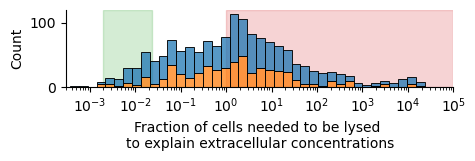

In [71]:
fig, ax = plt.subplots(1, figsize = (5, 1))
sns.histplot(data = df, x = 'Fraction of cells needed', log_scale=True, bins = 40, ax = ax, hue = 'Phase', multiple='stack',
             legend=False
             )

ax.axvspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured ratio of dead cells', zorder = 0)
ax.axvspan(1, 1e5, color = 'C3', alpha = 0.2, label = 'Infeasible', zorder = 0)
# sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 2, title = '')
ax.set_xlim(3e-4, 1e5)
ax.set_xlabel('Fraction of cells needed to be lysed \nto explain extracellular concentrations')

sns.despine()
plt.savefig(figure_folder / '5F_fraction_of_cells_needed_hist.pdf', bbox_inches='tight')


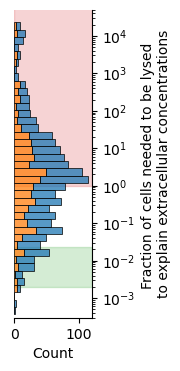

In [72]:
fig, ax = plt.subplots(1, figsize = (1, 4))
sns.histplot(data = df, y = 'Fraction of cells needed', log_scale=True, bins = 40, ax = ax, hue = 'Phase', multiple='stack',
             legend=False
             )

ax.axhspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured ratio of dead cells', zorder = 0)
ax.axhspan(1, 1e5, color = 'C3', alpha = 0.2, label = 'Infeasible', zorder = 0)
# sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 2, title = '')
ax.set_ylim(3e-4, 5e4)
ax.set_ylabel('Fraction of cells needed to be lysed \nto explain extracellular concentrations')
sns.despine(left = True, right = False)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


plt.savefig(figure_folder / '5F_fraction_of_cells_needed_hist_vertical.pdf', bbox_inches='tight')


In [73]:
(df.Hours==48).sum()/len(df)

np.float64(0.10344827586206896)

3.7e-04, 2.3e+04


/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_53440/2711715460.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([short_labels.get(lbl.get_text(), lbl.get_text()) for lbl in ax.get_xticklabels()],


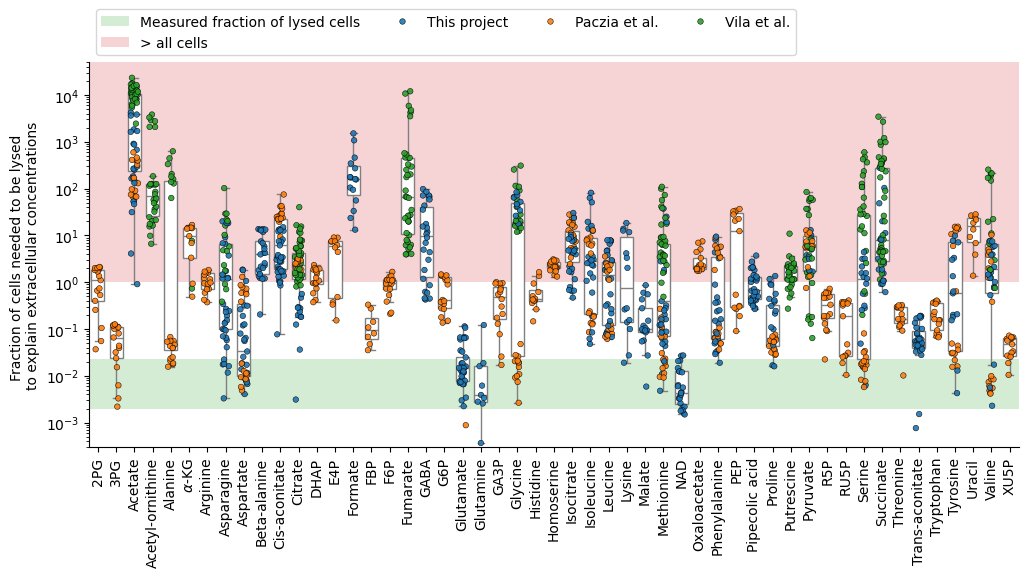

In [74]:
fig, ax = plt.subplots(1, figsize = (12, 5))
# ax.set_yscale('log')
hue_order = ['This project', 'Paczia et al.', 'Vila et al.']

ax.axhspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured fraction of lysed cells', zorder = 0, linewidth = 0)
ax.axhspan(1, 1e5, color = 'C3', alpha = 0.2, label = '> all cells', zorder = 0, linewidth = 0)
l = sns.boxplot(df, y = 'Fraction of cells needed', x = 'Metabolite', fill=True,gap=.1,
                ax = ax, legend = None, color = 'w',fliersize = 0, linecolor = 'grey', log_scale=True)
# sns.stripplot(data = df.loc[df.Hours == 48],y = 'Fraction of cells needed', x = 'Metabolite', ax = ax, edgecolor = 'k', 
#               linewidth = 0.7, size=4, jitter=0.2, hue = 'Dataset', alpha = 0.9, log_scale=True, 
#               hue_order=hue_order, legend=False)#, color = 'C0')
sns.stripplot(data = df,y = 'Fraction of cells needed', x = 'Metabolite', ax = ax, edgecolor = 'k',#'gray', 
              linewidth = 0.4, size=4, jitter=0.2, hue = 'Dataset', alpha = 0.9, log_scale=True,
              hue_order=hue_order)#, color = 'C0')
ax.set_ylim(3e-4, 5e4)
print(f'{df['Fraction of cells needed'].min():.1e}, {df['Fraction of cells needed'].max():.1e}')
ax.set_xlabel('')
ax.set_ylabel('Fraction of cells needed to be lysed \nto explain extracellular concentrations')
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 4, title = '')
sns.despine()

short_labels = {
    '2-phosphoglycerate': '2PG',
    '3-phosphoglycerate': '3PG',
    'Xylulose-5-phosphate': 'XU5P',
    'Ribulose-5-phosphate': 'RU5P',
    'Dihydroxyacetone phosphate': 'DHAP',
    'Alpha-ketoglutarate': r'$\alpha$-KG',
    'Erythrose-4-phosphate': 'E4P',
    'Glyceraldehyde-3-phosphate': 'GA3P',
    'Fructose-6-phosphate': 'F6P',
    'Glucose-6-phosphate': 'G6P',
    'Phosphoenolpyruvate': 'PEP',
    'Fructose-1,6-bisphosphate': 'FBP',
    'Gamma-aminobutyrate': 'GABA',
    'Ribose-5-phosphate': 'R5P',

}

ax.set_xticklabels([short_labels.get(lbl.get_text(), lbl.get_text()) for lbl in ax.get_xticklabels()],
                    rotation=90, ha='center')

plt.savefig(figure_folder / '5F_fraction_of_cells_needed_horizontal_dataset.pdf', bbox_inches='tight')

In [75]:
df.loc[df.Hours != 48].Hours.max()

28.0

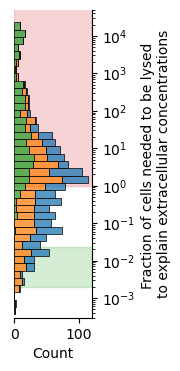

In [76]:
fig, ax = plt.subplots(1, figsize = (1, 4))
sns.histplot(data = df, y = 'Fraction of cells needed', log_scale=True, bins = 40, ax = ax, hue = 'Dataset', multiple='stack',
             legend=False
             )

ax.axhspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured ratio of dead cells', zorder = 0)
ax.axhspan(1, 1e5, color = 'C3', alpha = 0.2, label = 'Infeasible', zorder = 0)
# sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 2, title = '')
ax.set_ylim(3e-4, 5e4)
ax.set_ylabel('Fraction of cells needed to be lysed \nto explain extracellular concentrations')
sns.despine(left = True, right = False)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


plt.savefig(figure_folder / '5F_fraction_of_cells_needed_hist_vertical_dataset.pdf', bbox_inches='tight')


3.7e-04, 2.3e+04


/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_53440/242844511.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([short_labels.get(lbl.get_text(), lbl.get_text()) for lbl in ax.get_xticklabels()],


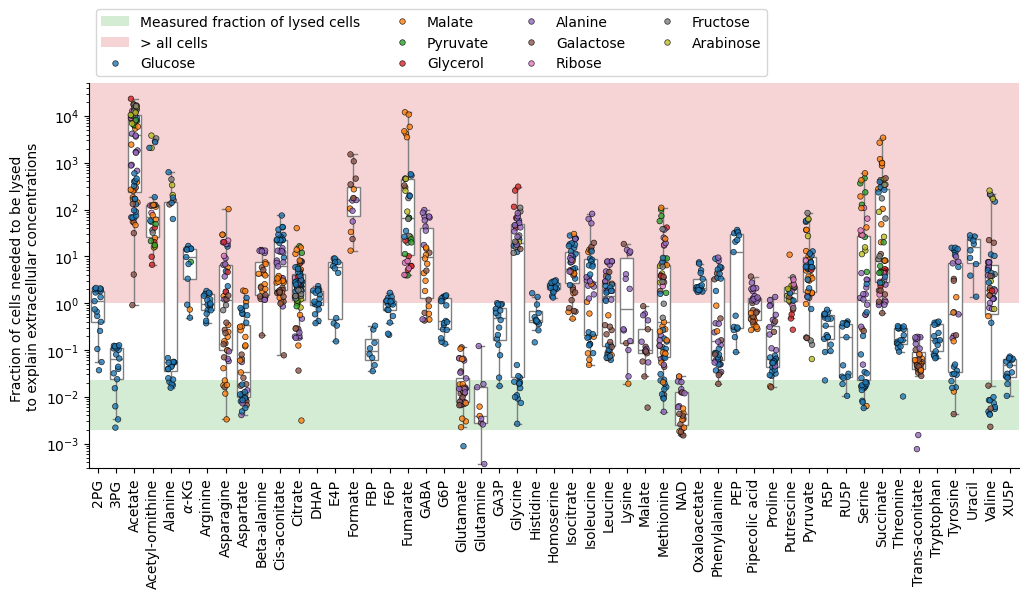

In [77]:
fig, ax = plt.subplots(1, figsize = (12, 5))
# ax.set_yscale('log')

df['Carbon source'] = df['Carbon source'].replace({'D-ribose': 'Ribose', 'D-galactose': 'Galactose', 'D-fructose': 'Fructose',
                                                  'L-alanine': 'Alanine', 'L-malate': 'Malate', 'L-arabinose': 'Arabinose',})
ax.axhspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured fraction of lysed cells', zorder = 0, linewidth = 0)
ax.axhspan(1, 1e5, color = 'C3', alpha = 0.2, label = '> all cells', zorder = 0, linewidth = 0)
l = sns.boxplot(df, y = 'Fraction of cells needed', x = 'Metabolite', fill=True,gap=.1,
                ax = ax, legend = None, color = 'w',fliersize = 0, linecolor = 'grey', log_scale=True)
sns.stripplot(data = df,y = 'Fraction of cells needed', x = 'Metabolite', ax = ax, edgecolor = 'k', 
              linewidth = 0.5, size=4, jitter=0.2, hue = 'Carbon source', alpha = 0.8, log_scale=True)#, color = 'C0')
ax.set_ylim(3e-4, 5e4)
print(f'{df['Fraction of cells needed'].min():.1e}, {df['Fraction of cells needed'].max():.1e}')
ax.set_xlabel('')
ax.set_ylabel('Fraction of cells needed to be lysed \nto explain extracellular concentrations')
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 4, title = '')
sns.despine()

short_labels = {
    '2-phosphoglycerate': '2PG',
    '3-phosphoglycerate': '3PG',
    'Xylulose-5-phosphate': 'XU5P',
    'Ribulose-5-phosphate': 'RU5P',
    'Dihydroxyacetone phosphate': 'DHAP',
    'Alpha-ketoglutarate': r'$\alpha$-KG',
    'Erythrose-4-phosphate': 'E4P',
    'Glyceraldehyde-3-phosphate': 'GA3P',
    'Fructose-6-phosphate': 'F6P',
    'Glucose-6-phosphate': 'G6P',
    'Phosphoenolpyruvate': 'PEP',
    'Fructose-1,6-bisphosphate': 'FBP',
    'Gamma-aminobutyrate': 'GABA',
    'Ribose-5-phosphate': 'R5P',

}

ax.set_xticklabels([short_labels.get(lbl.get_text(), lbl.get_text()) for lbl in ax.get_xticklabels()],
                    rotation=90, ha='center')

plt.savefig(figure_folder / '5F_fraction_of_cells_needed_horizontal_carbon_source.pdf', bbox_inches='tight')

(0.0003, 100000.0)

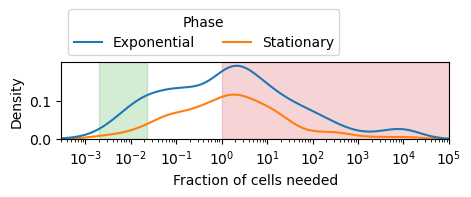

In [78]:
fig, ax = plt.subplots(1, figsize = (5, 1))
sns.kdeplot(data = df, x = 'Fraction of cells needed', log_scale=True, ax = ax, hue = 'Phase')
ax.axvspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured ratio of dead cells', zorder = 0)
ax.axvspan(1, 1e5, color = 'C3', alpha = 0.2, label = 'Infeasible', zorder = 0)
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 2)
ax.set_xlim(3e-4, 1e5)


In [128]:
(df['Fraction of cells needed']<0.023).sum()

np.int64(157)

In [129]:
(df['Fraction of cells needed']<0.023).sum()/len(df['Fraction of cells needed'])

np.float64(0.10411140583554376)

In [81]:
(df['Fraction of cells needed']>1).sum(), (df['Fraction of cells needed']>1).sum()/len(df['Fraction of cells needed'])

(np.int64(849), np.float64(0.5629973474801061))

In [133]:
157/1508


0.10411140583554376

# Include protein depolymerization

In [83]:
aa_mass_fractions = {
    'ala__L': 0.046,
    'arg__L': 0.052,
    'asp__L': 0.026,# Halv of the joint asp/asn value
    'asn__L': 0.026,# Halv of the joint asp/asn value
    'cys__L': 0.01,
    'glu__L': 0.0245, # Halv of the joint glu/gln value
    'gln__L': 0.0245, # Halv of the joint glu/gln value
    'gly': 0.025,
    'his__L': 0.012,
    'ile__L': 0.026,
    'leu__L': 0.05,
    'lys__L': 0.036,
    'met__L': 0.018,
    'phe__L': 0.028,
    'pro__L': 0.022,
    'ser__L': 0.021,
    'thr__L': 0.028,
    'trp__L': 0.012,
    'tyr__L': 0.016,
    'val__L': 0.033
}


OD_to_gDW = 0.346 # gDW/L/OD


metabolite_to_bigg_aa = {
    'Leucine': 'leu__L',
    'Glutamate': 'glu__L',
    'Aspartate': 'asp__L',
    'Asparagine': 'asn__L',
    'Glutamine': 'gln__L',
    'Alanine': 'ala__L',
    'Glycine': 'gly',
    'Serine': 'ser__L', 
    'Threonine': 'thr__L',
    'Valine': 'val__L',
    'Isoleucine': 'ile__L',
    'Phenylalanine': 'phe__L',
    'Tyrosine': 'tyr__L',
    'Tryptophan': 'trp__L',
    'Cysteine': 'cys__L',
    'Histidine': 'his__L',
    'Methionine': 'met__L',
    'Proline': 'pro__L',
    'Arginine': 'arg__L',
    'Lysine': 'lys__L'
    }

aa_mol_weight_dict = {
    'ala__L': 89.1,
    'arg__L': 174.2,
    'asp__L': 133.1,
    'asn__L': 132.1,
    'cys__L': 121.2,
    'glu__L': 147.1,
    'gln__L': 146.2,
    'gly': 75.1,
    'his__L': 155.2,
    'ile__L': 131.2,
    'leu__L': 131.2,
    'lys__L': 146.2,
    'met__L': 149.2,
    'phe__L': 165.2,
    'pro__L': 115.1,
    'ser__L': 105.1,
    'thr__L': 119.1,
    'trp__L': 204.2,
    'tyr__L': 181.2,
    'val__L': 117.1
}

OD_to_gDW = defaultdict(lambda: 0.36)

OD_to_gDW.update({
    'Glucose': 0.346,
    'Galactose': 0.346,
    'L-malate': 0.279,
    'L-alanine': 0.296,
})

In [84]:
df['gDW/L'] = df['OD'] * df['Carbon source'].map(OD_to_gDW)

In [85]:
df_AA = df.loc[df['Metabolite'].isin(metabolite_to_bigg_aa.keys())].copy()

In [86]:
for i, row in df_AA.iterrows():
    aa = metabolite_to_bigg_aa[row['Metabolite']]
    df_AA.at[i, 'gAA/L'] = row['gDW/L'] * aa_mass_fractions[aa]
    # Substract water weight (18.02 g/mol) because one water molecule is lost during protein synthesis
    df_AA.at[i, 'AA uM'] = df_AA.at[i, 'AA uM'] = df_AA.at[i, 'gAA/L'] / (aa_mol_weight_dict[aa]-18.02) *1e6

In [87]:
df_AA[r'Fraction of cells needed (100% depolymerization)'] = df['Delta concentration [uM]']/(df_AA['AA uM']+df_AA['Corresponding Ex. concentration [uM]'])
df_AA[r'Fraction of cells needed (10% depolymerization)'] = df['Delta concentration [uM]']/((0.1*df_AA['AA uM'])+df_AA['Corresponding Ex. concentration [uM]'])

In [88]:
df_death_aaL = df_AA.melt(id_vars=['Metabolite', 'Phase', 'Hours', 'Carbon source', 'Dataset', 'gDW/L', 'OD'],
                                value_vars=['Fraction of cells needed (100% depolymerization)',
                                            'Fraction of cells needed (10% depolymerization)',
                                            'Fraction of cells needed'
                                ],
                                var_name='Protein depolymerization', value_name='Fraction needed')

df_death_aaL.replace({'Protein depolymerization':
                      {'Fraction of cells needed': '0%',
                        'Fraction of cells needed (10% depolymerization)': '10%',
                        'Fraction of cells needed (100% depolymerization)': '100%',}}, inplace=True)


In [89]:
df_death_aaL

,Metabolite,Phase,Hours,Carbon source,Dataset,gDW/L,OD,Protein depolymerization,Fraction needed
0,Alanine,Stationary,14.0,Glucose,Paczia et al.,5.307640,15.3400,100%,0.000310
1,Alanine,Stationary,15.0,Glucose,Paczia et al.,4.992780,14.4300,100%,0.000319
2,Alanine,Stationary,17.0,Glucose,Paczia et al.,4.709060,13.6100,100%,0.000264
3,Alanine,Stationary,26.0,Glucose,Paczia et al.,4.570660,13.2100,100%,0.000386
4,Alanine,Exponential,48.0,Galactose,Vila et al.,0.053007,0.1532,100%,3.003028
...,...,...,...,...,...,...,...,...,...
1942,Valine,Exponential,8.0,Glucose,Paczia et al.,4.601800,13.3000,0%,0.008425
1943,Valine,Stationary,22.0,Alanine,This project,0.900000,2.5000,0%,3.912986
1944,Valine,Exponential,9.0,Glucose,Paczia et al.,5.515240,15.9400,0%,0.009877
1945,Valine,Exponential,8.0,Galactose,This project,0.155700,0.4500,0%,0.017336


In [90]:
df_death_aaL.columns

Index(['Metabolite', 'Phase', 'Hours', 'Carbon source', 'Dataset', 'gDW/L',
       'OD', 'Protein depolymerization', 'Fraction needed'],
      dtype='object')

/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_53440/3425372831.py:10: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data = df_death_aaL.loc[df_death_aaL.Hours != 48], y = 'Fraction needed', x = 'Metabolite', ax = ax, edgecolor = 'gray',
/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_53440/3425372831.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center', size = 12)


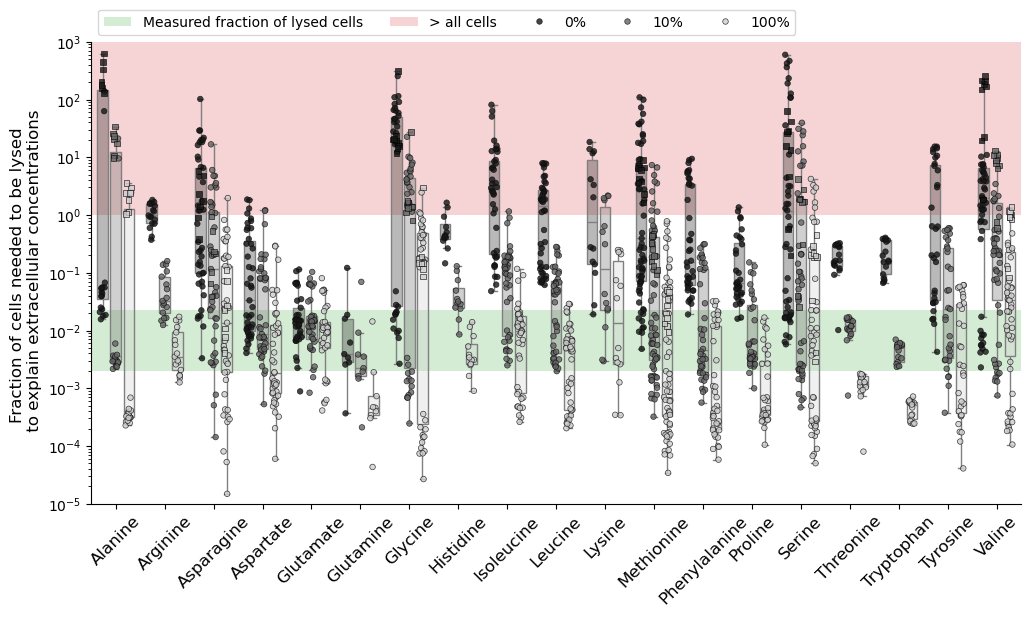

In [91]:
fig, ax = plt.subplots(1, figsize = (12, 6))
ax.set_yscale('log')
gray_colors = [ "#171717", "#666666", "#cfcfcf"]
hue_order = ['0%', '10%', '100%']
ax.axhspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured fraction of lysed cells', zorder = 0, linewidth = 0)
ax.axhspan(1, 1e5, color = 'C3', alpha = 0.2, label = '> all cells', zorder = 0, linewidth = 0)
sns.boxplot(df_death_aaL, y = 'Fraction needed', x = 'Metabolite', fill=True,gap=.2,
                ax = ax, hue = 'Protein depolymerization', legend = None,fliersize = 0,
                 linecolor = 'grey', palette=gray_colors, hue_order=hue_order)#, boxprops=dict(alpha=.3))
sns.stripplot(data = df_death_aaL.loc[df_death_aaL.Hours != 48], y = 'Fraction needed', x = 'Metabolite', ax = ax, edgecolor = 'gray',
              dodge=True, 
              hue_order=hue_order,
              palette=gray_colors,
              linewidth = 0.5, size=4, jitter=0.2, hue = 'Protein depolymerization', alpha = 0.8)#, color = 'C0')

sns.stripplot(data = df_death_aaL.loc[df_death_aaL.Hours == 48], y = 'Fraction needed', x = 'Metabolite', ax = ax, edgecolor = 'k',
              dodge=True, 
              marker='s',
              hue_order=hue_order,
              palette=gray_colors,legend=False,
              linewidth = 0.5, size=4, jitter=0.2, hue = 'Protein depolymerization', alpha = 0.8)#, color = 'C0')


for patch in ax.patches:
    fc = patch.get_facecolor()
    patch.set_facecolor((*fc[:3], 0.3))  # Set alpha to 0.3
# for patch in ax.artists:
#     print(patch)
#     fc = patch.get_facecolor()
#     patch.set_facecolor(plt.colors.to_rgba(fc, 0.3))
# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center', size = 12)
# print(df_death_aaL['Fraction needed'].min(), df_death_aaL['Fraction needed'].max())
ax.set_ylim(1e-5, 1e3)
ax.set_xlabel('')
ax.set_ylabel('Fraction of cells needed to be lysed \n to explain extracellular concentrations', fontsize=12)
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 5, title = '')
sns.despine()
plt.savefig(figure_folder / '5F_fraction_of_cells_needed_AA.pdf', bbox_inches='tight')

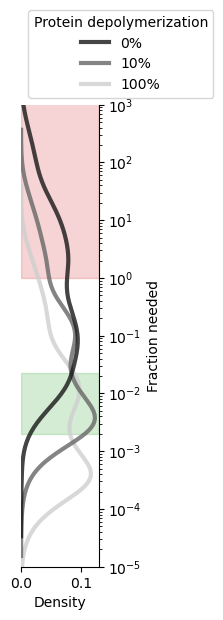

In [92]:
fig, ax = plt.subplots(1, figsize = (1, 6))
sns.kdeplot(data = df_death_aaL, y = 'Fraction needed', log_scale=True, ax = ax, 
            hue = 'Protein depolymerization', palette=gray_colors, lw = 3, 
            hue_order=hue_order,
            alpha = 0.8)
ax.axhspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured ratio of dead cells', zorder = 0)
ax.axhspan(1, 1e5, color = 'C3', alpha = 0.2, label = 'Infeasible', zorder = 0)
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 1)
ax.set_ylim(1e-5, 1e3)
sns.despine(left = True, right = False)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.savefig(figure_folder / '5F_fraction_of_cells_needed_AA_kde.pdf', bbox_inches='tight')


In [108]:
threshold = 0.023
for pp in [0, 10, 100]:
    dfd_aa_i = df_death_aaL[df_death_aaL['Protein depolymerization'] == f'{pp}%'].copy()
    total_counts_aad = dfd_aa_i.groupby('Metabolite').size()
    below_counts_aad = dfd_aa_i[dfd_aa_i['Fraction needed'] < threshold].groupby('Metabolite').size()
    fraction_below_aad = (below_counts_aad / total_counts_aad).fillna(0)
    fraction_below_aad = pd.DataFrame(fraction_below_aad, columns=['Fraction of cells below threshold'])
    fraction_below_aad['Protein depolymerization'] = f'{pp}%'
    if pp == 0:
        fraction_below_aa = fraction_below_aad
    else:
        fraction_below_aa = pd.concat([fraction_below_aa, fraction_below_aad])      

In [112]:
fraction_below_aa['Above 50%'] = fraction_below_aa['Fraction of cells below threshold'] > 0.5


<Axes: xlabel='Fraction of cells below threshold', ylabel='Metabolite'>

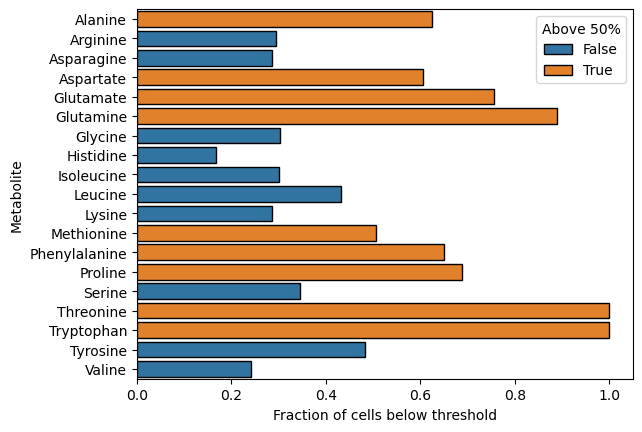

In [127]:
idx10 = fraction_below_aa['Protein depolymerization']=='10%'
sns.barplot(data = fraction_below_aa.loc[idx10], y = fraction_below_aa.loc[idx10].index, 
            x = 'Fraction of cells below threshold', hue = 'Above 50%',
            orient='horizontal', palette=['C0', 'C1'], edgecolor='k')


In [119]:
fraction_below_aa.groupby('Protein depolymerization')['Above 50%'].sum()

Protein depolymerization
0%       2
10%      9
100%    16
Name: Above 50%, dtype: int64

In [94]:
for patch in ax.artists:
    print(patch)
    fc = patch.get_facecolor()
    patch.set_facecolor(plt.colors.to_rgba(fc, 0.3))

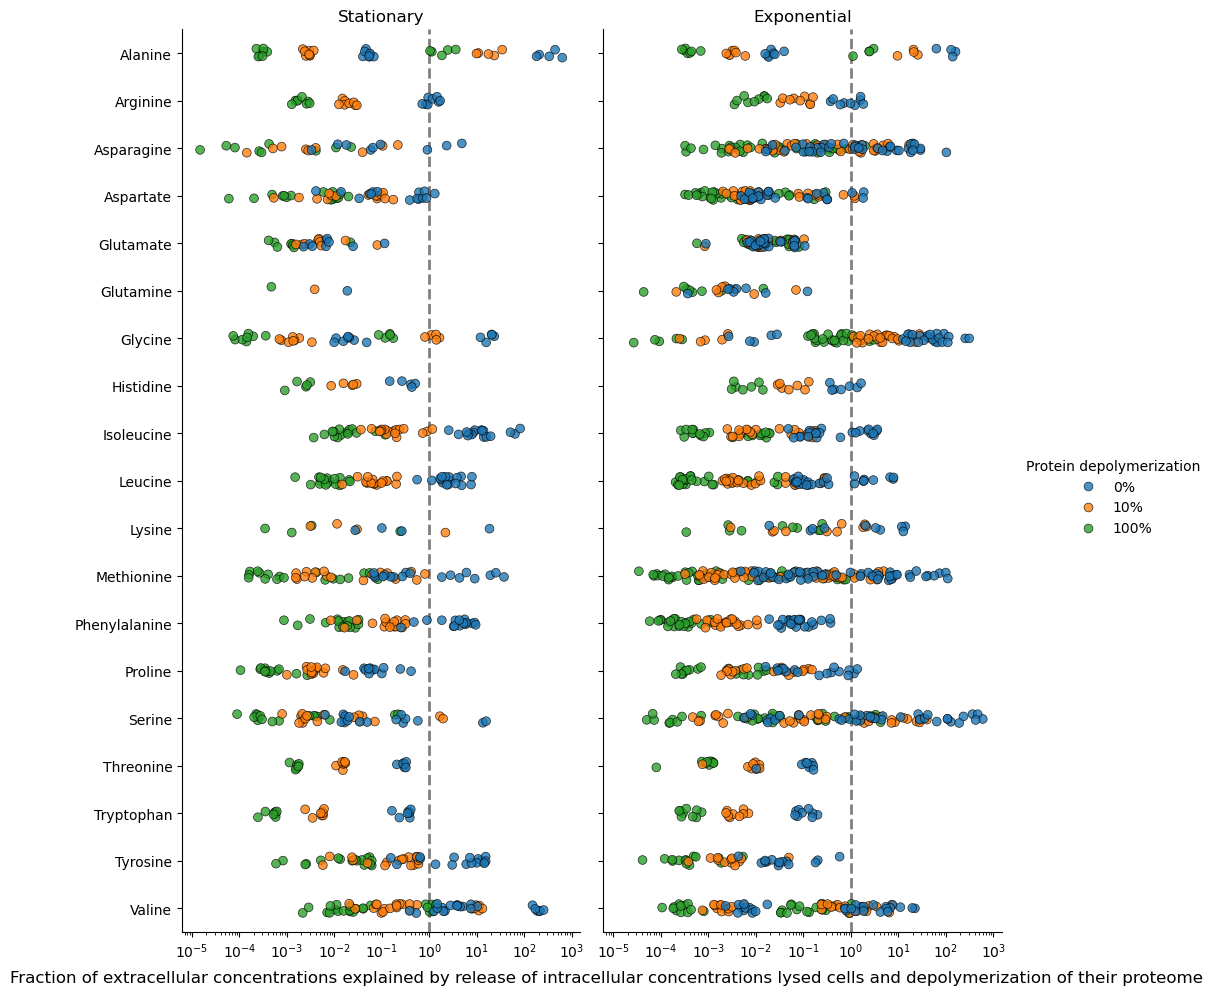

In [95]:

strip = sns.catplot(df_death_aaL, x = 'Fraction needed', #hue = 'Protein depolymerization',
                        y = 'Metabolite',col = 'Phase',
                        hue= 'Protein depolymerization',
                        log_scale=True,
                        edgecolor = 'k', linewidth = 0.5, alpha = 0.8,\
                        s = 40,
                        kind = 'strip',
                        hue_order=['0%', '10%', '100%'],
                        height=10, aspect=0.5,
                    #    figsize=(6, 3), 
                    #    order=aa_metabolite_order
                       )
strip.set_titles(col_template="{col_name}", row_template="{row_name}", size = 12)
strip.set_axis_labels("","")
strip.figure.supxlabel("Fraction of extracellular concentrations explained by release of " \
"intracellular concentrations lysed cells and depolymerization of their proteome", size = 12)

sns.despine()

for ax in strip.axes.flat:
    ax.axvline(x=1, color='k', ls='--', lw=2, alpha=0.5, zorder = 0)
# yticks = np.arange(len(metabolite_order))
# for i, y in enumerate(yticks):
#     color = "#ffffff" if i % 2 == 0 else "#eeeded"
#     strip.axes[0,0].axhspan(y - 0.5, y + 0.5, color=color, zorder=0)


# fig_fn = figure_folder / '2_paired_death_1_with_aa.pdf'
# plt.savefig(fig_fn, bbox_inches='tight')

# All iML1515 biomass components

In [96]:
model_fn = data_folder / '..' / 'models' / 'e_coli'/ 'iML1515.xml'
model = cobra.io.read_sbml_model(model_fn)

In [97]:
met_info_fn = data_folder / 'this_project/5_div/5C_metabolite_info.csv'
met_name_to_abbrv = pd.read_csv(met_info_fn, index_col=0).set_index('Metabolite')['Metabolite id'].to_dict()

In [98]:
df['BiGG ID'] = df['Metabolite'].map(met_name_to_abbrv)

In [99]:
biomass_consumed_dict = {m.id: c for m,c in model.reactions.BIOMASS_Ec_iML1515_WT_75p37M.metabolites.items() if c < 0} # mmol/gDW
biomass_produced_dict = {m.id: c for m,c in model.reactions.BIOMASS_Ec_iML1515_WT_75p37M.metabolites.items() if c > 0} # mmol/gDW


In [100]:
# Given in iAF1260 paper supp 3 https://pmc.ncbi.nlm.nih.gov/articles/PMC1911197
metabolites_soluble_pool = ['ptrc', 'spmd', 'accoa', 'coa', 'succoa', 'malcoa', 'nad', 'nadh', 'nadp', 'nadph', 'fad', 'thf', 'mlthf', '5mthf', 'thmpp', 'q8h2', '2dmmql8', 'mql8', 'pydx5p', 'hemeO', 'pheme', 'sheme',
                            'enter', 'gthrd', 'adocbl', 'udcpdp', '10fthf', 'chor', 'amet', 'ribflv']

biomass_consumed_dictnot_soluble = {m[:-2]: c for m, c in biomass_consumed_dict.items() if m[:-2] not in metabolites_soluble_pool}

In [101]:
biomass_consumed_dictnot_soluble

{'2fe2s': -2.5e-05,
 '4fe4s': -0.000248,
 'ala__L': -0.499149,
 'arg__L': -0.28742,
 'asn__L': -0.234232,
 'asp__L': -0.234232,
 'atp': -75.55223,
 'btn': -2e-06,
 'ca2': -0.004952,
 'cl': -0.004952,
 'clpn160': -0.002944,
 'clpn161': -0.00229,
 'clpn181': -0.00118,
 'cobalt2': -2.4e-05,
 'colipa': -0.008151,
 'ctp': -0.129799,
 'cu2': -0.000674,
 'cys__L': -0.088988,
 'datp': -0.024805,
 'dctp': -0.025612,
 'dgtp': -0.025612,
 'dttp': -0.024805,
 'fe2': -0.006388,
 'fe3': -0.007428,
 'gln__L': -0.255712,
 'glu__L': -0.255712,
 'gly': -0.595297,
 'glycogen': -0.154187,
 'gtp': -0.209121,
 'h2o': -70.028756,
 'his__L': -0.092056,
 'ile__L': -0.282306,
 'k': -0.18569,
 'leu__L': -0.437778,
 'lipopb': -3e-06,
 'lys__L': -0.333448,
 'met__L': -0.149336,
 'mg2': -0.008253,
 'mn2': -0.000658,
 'mobd': -7e-06,
 'mococdp': -7e-06,
 'mocogdp': -7e-06,
 'murein3p3p': -0.001345,
 'murein3px4p': -0.000605,
 'murein4p4p': -0.005381,
 'murein4px4p': -0.005448,
 'murein4px4px4p': -0.000673,
 'nh4': -

In [102]:
for i, row in df.iterrows():
    if row['BiGG ID'] in biomass_consumed_dictnot_soluble.keys():
        df.at[i, 'Biomass fraction [mmol/gDW]'] = -biomass_consumed_dictnot_soluble[row['BiGG ID']]
        df.at[i, 'Biomass component'] = True
    else:
        df.at[i, 'Biomass component'] = False
        df.at[i, 'Biomass consumed [mmol/gDW]'] = np.nan

In [103]:
# Add a marker above each column if 'Biomass component' is True
biomass_component_dict = df.groupby('Metabolite')['Biomass component'].any().to_dict()

# Plot

3.7e-04, 2.3e+04


/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_53440/1084733925.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([short_labels.get(lbl.get_text(), lbl.get_text()) for lbl in ax.get_xticklabels()],


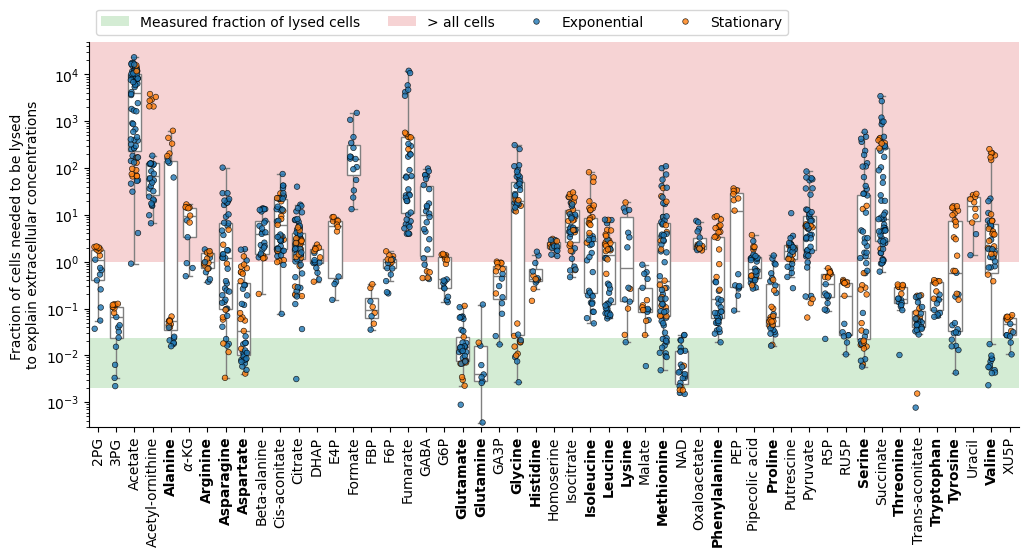

In [104]:
fig, ax = plt.subplots(1, figsize = (12, 5))
# ax.set_yscale('log')

ax.axhspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured fraction of lysed cells', zorder = 0, linewidth = 0)
ax.axhspan(1, 1e5, color = 'C3', alpha = 0.2, label = '> all cells', zorder = 0, linewidth = 0)
l = sns.boxplot(df, y = 'Fraction of cells needed', x = 'Metabolite', fill=True,gap=.1,
                ax = ax, legend = None, color = 'w',fliersize = 0, linecolor = 'grey', log_scale=True)
sns.stripplot(data = df,y = 'Fraction of cells needed', x = 'Metabolite', ax = ax, edgecolor = 'k', 
              linewidth = 0.5, size=4, jitter=0.2, hue = 'Phase', alpha = 0.8, log_scale=True)#, color = 'C0')
ax.set_ylim(3e-4, 5e4)
print(f'{df['Fraction of cells needed'].min():.1e}, {df['Fraction of cells needed'].max():.1e}')
ax.set_xlabel('')
ax.set_ylabel('Fraction of cells needed to be lysed \nto explain extracellular concentrations')
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1), ncol = 4, title = '')
sns.despine()

short_labels = {
    '2-phosphoglycerate': '2PG',
    '3-phosphoglycerate': '3PG',
    'Xylulose-5-phosphate': 'XU5P',
    'Ribulose-5-phosphate': 'RU5P',
    'Dihydroxyacetone phosphate': 'DHAP',
    'Alpha-ketoglutarate': r'$\alpha$-KG',
    'Erythrose-4-phosphate': 'E4P',
    'Glyceraldehyde-3-phosphate': 'GA3P',
    'Fructose-6-phosphate': 'F6P',
    'Glucose-6-phosphate': 'G6P',
    'Phosphoenolpyruvate': 'PEP',
    'Fructose-1,6-bisphosphate': 'FBP',
    'Gamma-aminobutyrate': 'GABA',
    'Ribose-5-phosphate': 'R5P',

}

ax.set_xticklabels([short_labels.get(lbl.get_text(), lbl.get_text()) for lbl in ax.get_xticklabels()],
                    rotation=90, ha='center')
xticklabels = ax.get_xticklabels()
for lbl in xticklabels:
    met_name = lbl.get_text()
    if biomass_component_dict.get(met_name, False):
        # lbl.set_text(lbl.get_text() + ' *')  # Add a marker for biomass components
        lbl.set_color('k')  # Change color to indicate biomass component
        lbl.set_fontweight('bold')



# plt.savefig(figure_folder / '5F_fraction_of_cells_needed_horizontal.pdf', bbox_inches='tight')

In [105]:
sintef_df.Hours.max()

22.0